# Inspect Trained Model

In [24]:
import os
import sys
import itertools
import math
import logging
import json
import re
import random
from collections import OrderedDict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon
from pathlib import Path

import tensorflow as tf
%matplotlib inline

# Root directory of the project
ROOT_DIR = os.path.abspath("../final_project/")
MASK_PATH = '/Akamai/rgradilla/final_project/Mask_RCNN'
DATA_DIR = Path('/Akamai/rgradilla/final_project/imaterialist')
COCO_WEIGHTS_PATH = os.path.join(MASK_PATH, "mask_rcnn_coco.h5")
DEFAULT_LOGS_DIR = os.path.join(MASK_PATH, "logs")

# Import Mask RCNN
sys.path.append(MASK_PATH)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log


from fashion import *

### Configurations

In [25]:
class imaterialistConfig(Config):
    """ Configuration for training on imaterialist images.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "imaterialist"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 2

    # Number of classes (including background)
    NUM_CLASSES = 1 + 46  # Background + classIds

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 100

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9
    
    ## TESTING
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    
    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels
    
    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32
    
    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5

In [26]:
config = imaterialistConfig()
DATA_DIR = Path('/Akamai/rgradilla/final_project/imaterialist')

In [27]:
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    
config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                59
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_bbox_loss': 1.0, 'rpn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0, 'mrcnn_class_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [28]:
TEST_MODE = 'inference'

In [29]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Data preparation

In [30]:
train_df = pd.read_csv('/Akamai/rgradilla/final_project/imaterialist/train.csv')
train_df = train_df.drop('AttributesIds', axis=1)

image_df = train_df.groupby('ImageId')['EncodedPixels', 'ClassId'].agg(lambda x: list(x))
size_df = train_df.groupby('ImageId')['Height', 'Width'].mean()
image_df = image_df.join(size_df, on='ImageId')

In [31]:
image_df.head(7)

,EncodedPixels,ClassId,Height,Width
ImageId,,,,
00000663ed1ff0c4e0132b9b9ac53f6e,[6068157 7 6073371 20 6078584 34 6083797 48 60...,"[6, 0, 28, 31, 32, 32, 31, 29, 4]",5214,3676
0000fe7c9191fba733c8a69cfaf962b7,[2201176 1 2203623 3 2206071 5 2208518 8 22109...,"[33, 1]",2448,2448
0002ec21ddb8477e98b2cbb87ea2e269,[2673735 2 2676734 8 2679734 13 2682733 19 268...,"[33, 10, 23, 23]",3000,1997
0002f5a0ebc162ecfb73e2c91e3b8f62,[435 132 1002 132 1569 132 2136 132 2703 132 3...,"[10, 33, 15]",567,400
0004467156e47b0eb6de4aa6479cbd15,[132663 8 133396 25 134130 41 134868 53 135611...,"[10, 33, 31, 31, 15]",750,500
00048c3a2fb9c29340473c4cfc06424a,[239016 3 239989 6 240963 7 241938 8 242913 9 ...,"[13, 1, 33, 8, 35, 24, 23, 23]",975,650
0006ea84499fd9a06fefbdf47a5eb4c0,[73327 6 74328 18 75330 37 76335 63 77340 88 7...,"[1, 33, 8, 23, 23]",1000,667


In [32]:
with open('/Akamai/rgradilla/final_project/imaterialist/label_descriptions.json', 'r') as file:
            label_desc = json.load(file)

In [33]:
class imaterialistDataset(utils.Dataset):
    
    def __init__(self, df):
        super().__init__(self)
        
        self.IMAGE_SIZE = 256
        
        # Add classes
        for cat in label_desc['categories']:
            self.add_class('fashion', cat.get('id'), cat.get('name'))
        
        # Add images
        for i, row in df.iterrows():
            self.add_image("fashion", 
                           image_id=row.name, 
                           path= '/Akamai/rgradilla/final_project/imaterialist/train/{}.jpg'.format(row.name), 
                           labels=row['ClassId'],
                           annotations=row['EncodedPixels'], 
                           height=row['Height'], width=row['Width'])
            
    def _resize_image(self, image_path):
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (self.IMAGE_SIZE, self.IMAGE_SIZE), interpolation=cv2.INTER_AREA)  
        return img
        
    def load_image(self, image_id):
        return self._resize_image(self.image_info[image_id]['path'])
       
    def load_mask(self, image_id):
        info = self.image_info[image_id]
                
        mask = np.zeros((self.IMAGE_SIZE, self.IMAGE_SIZE, len(info['annotations'])), dtype=np.uint8)
        labels = []
        
        for m, (annotation, label) in enumerate(zip(info['annotations'], info['labels'])):
            sub_mask = np.full(info['height']*info['width'], 0, dtype=np.uint8)
            annotation = [int(x) for x in annotation.split(' ')]
            
            for i, start_pixel in enumerate(annotation[::2]):
                sub_mask[start_pixel: start_pixel+annotation[2*i+1]] = 1

            sub_mask = sub_mask.reshape((info['height'], info['width']), order='F')
            sub_mask = cv2.resize(sub_mask, (self.IMAGE_SIZE, self.IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)
            
            mask[:, :, m] = sub_mask
            labels.append(int(label)+1)
            
        return mask, np.array(labels, dtype='int32')
    
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path'], [x for x in info['labels']]

## Load Dataset

In [34]:
dataset = imaterialistDataset(image_df)
dataset.prepare()

## Load Model

In [35]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
#DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0
DEVICE = "/gpu:0" 

# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", 
                          model_dir=MASK_PATH,
                          config=config)

In [36]:
# this is the last model's weights
IMATERIALIST_WEIGHTS_PATH = '/Akamai/rgradilla/final_project/Mask_RCNN/mrcnn/imaterialist20200506T1750/mask_rcnn_imaterialist_0030.h5'

weights_path = IMATERIALIST_WEIGHTS_PATH

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  /Akamai/rgradilla/final_project/Mask_RCNN/mrcnn/imaterialist20200506T1750/mask_rcnn_imaterialist_0030.h5
Re-starting from epoch 30


## Sample Image

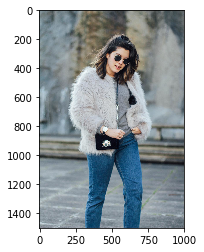

In [37]:
test_img_path = '/Akamai/rgradilla/final_project/imaterialist/train/0a3950d9598aa09e7d59f9de113ffa6b.jpg'
image = plt.imread(test_img_path)
plt.imshow(image)

## Run Detection

Processing 1 images
image                    shape: (1500, 1000, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 59)               min:    0.00000  max: 1500.00000  float64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32


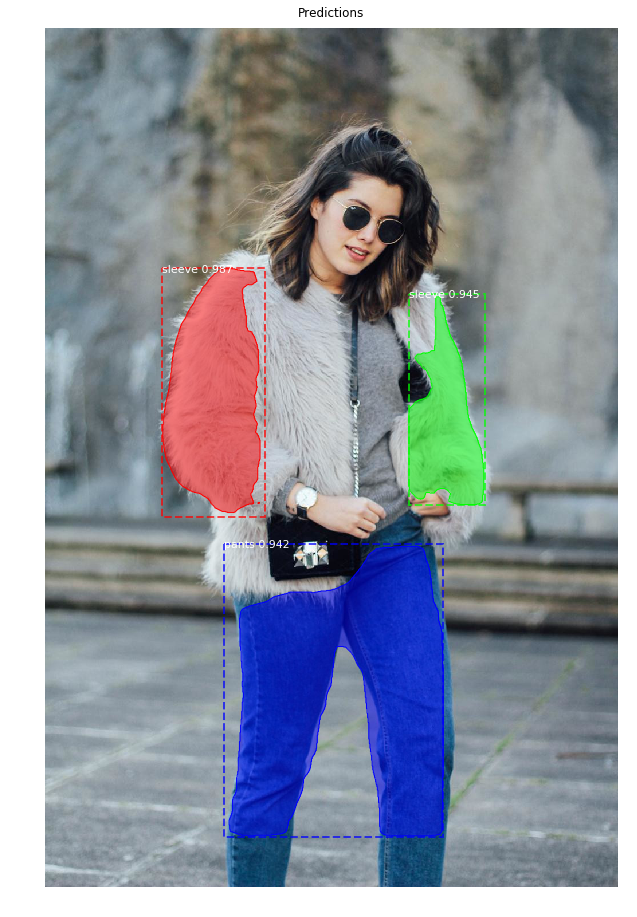

In [38]:
# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")

## Sample Prediction

Processing 1 images
image                    shape: (1946, 1295, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  146.10000  float64
image_metas              shape: (1, 59)               min:    0.00000  max: 1946.00000  float64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32


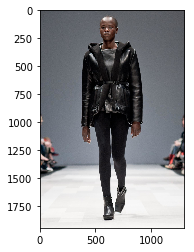

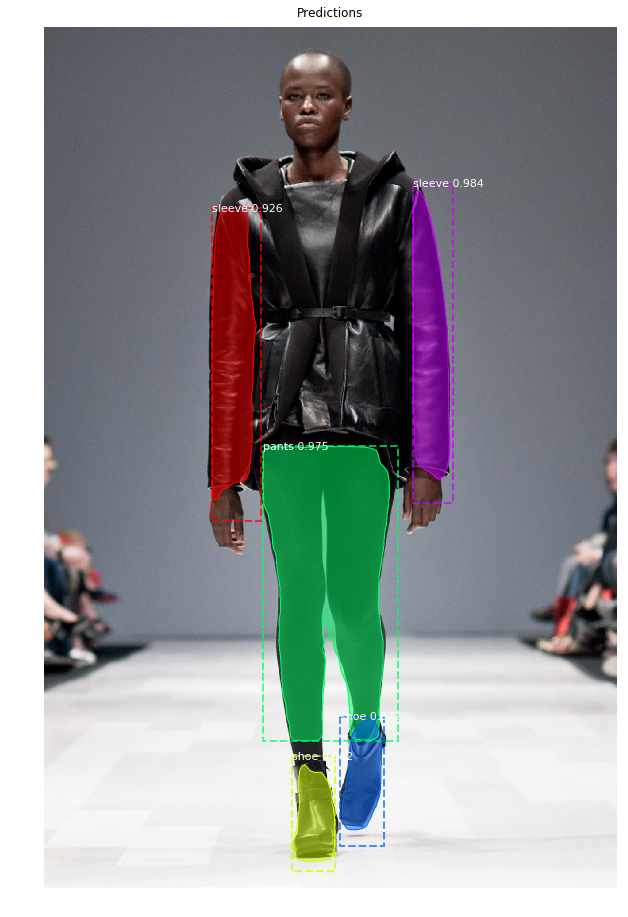

In [39]:
test_img_path = '/Akamai/rgradilla/final_project/imaterialist/train/0ac6d13ca245107c4d1b17904130c338.jpg'
image = plt.imread(test_img_path)
plt.imshow(image)

# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")

# Random image Prediction

image ID: fashion.23d1c20c9ab876c927a7b9960dcb30c5 (6424) ('/Akamai/rgradilla/final_project/imaterialist/train/23d1c20c9ab876c927a7b9960dcb30c5.jpg', [32, 9, 8, 1, 31, 31, 23, 23, 43, 43, 43, 19, 19, 25, 31, 31, 32])
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 59)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32
gt_class_id              shape: (17,)                 min:    2.00000  max:   44.00000  int32
gt_bbox                  shape: (17, 4)               min:    9.00000  max:  250.00000  int32
gt_mask                  shape: (256, 256, 17)        min:    0.00000  max:    1.00000  uint8


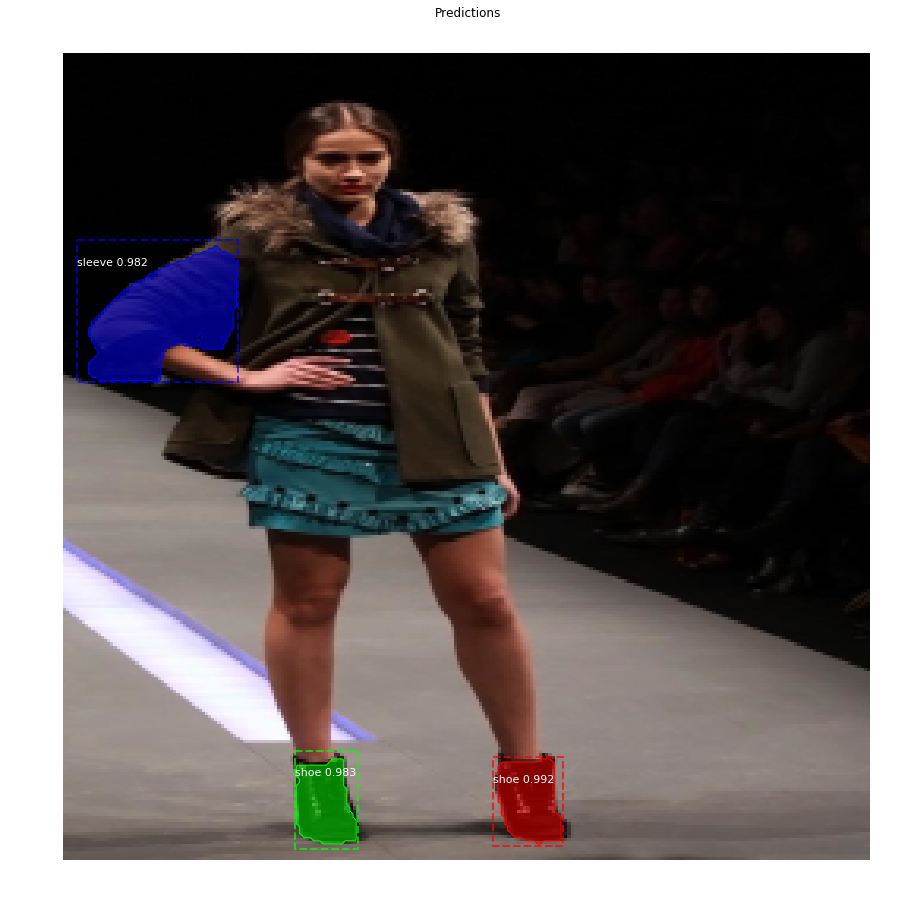

In [40]:
# Select a random image
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")

log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

In [57]:
# 790, 17274

18868

In [47]:
dataset_train = dataset

#Selected image
image_id = 790
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_train, config, image_id, use_mini_mask=False)
info = dataset_train.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset_train.image_reference(image_id)))

# Run object detection
results = model.detect([image], verbose=1)

image ID: fashion.0461935888bad18244f11e67e7d3b417 (790) ('/Akamai/rgradilla/final_project/imaterialist/train/0461935888bad18244f11e67e7d3b417.jpg', [23, 23, 6, 32, 42, 32, 1, 31, 31, 33])
Processing 1 images
image                    shape: (256, 256, 3)         min:   56.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min:  -67.70000  max:  151.10000  float64
image_metas              shape: (1, 59)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32


gt_class_id              shape: (10,)                 min:    2.00000  max:   43.00000  int32
gt_bbox                  shape: (10, 4)               min:   23.00000  max:  225.00000  int32
gt_mask                  shape: (256, 256, 10)        min:    0.00000  max:    1.00000  uint8


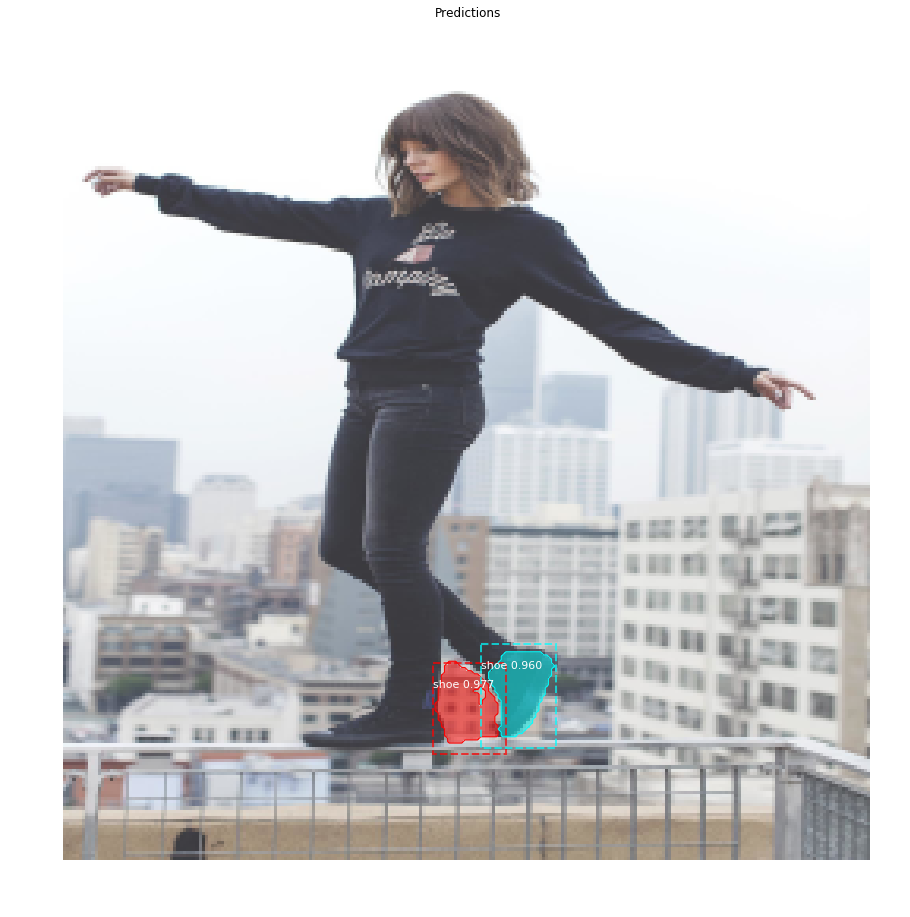

In [48]:
# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_train.class_names, r['scores'], ax=ax,
                            title="Predictions")

log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

In [87]:
image_id

17274

# Step by Step Prediction

## Stage 1: Region Proposal Network

The Region Proposal Network (RPN) runs a lightweight binary classifier on a lot of boxes (anchors) over the image and returns object/no-object scores. Anchors with high objectness score (positive anchors) are passed to the stage two to be classified.
Often, even positive anchors don't cover objects fully. So the RPN also regresses a refinement (a delta in location and size) to be applied to the anchors to shift it and resize it a bit to the correct boundaries of the object.

### 1.a RPN Targets

The RPN targets are the training values for the RPN. To generate the targets, we start with a grid of anchors that cover the full image at different scales, and then we compute the IoU of the anchors with ground truth object. Positive anchors are those that have an IoU >= 0.7 with any ground truth object, and negative anchors are those that don't cover any object by more than 0.3 IoU. Anchors in between (i.e. cover an object by IoU >= 0.3 but < 0.7) are considered neutral and excluded from training.
To train the RPN regressor, we also compute the shift and resizing needed to make the anchor cover the ground truth object completely.

In [36]:
# Generate RPN trainig targets
# target_rpn_match is 1 for positive anchors, -1 for negative anchors
# and 0 for neutral anchors.
target_rpn_match, target_rpn_bbox = modellib.build_rpn_targets(
    image.shape, model.anchors, gt_class_id, gt_bbox, model.config)
log("target_rpn_match", target_rpn_match)
log("target_rpn_bbox", target_rpn_bbox)

positive_anchor_ix = np.where(target_rpn_match[:] == 1)[0]
negative_anchor_ix = np.where(target_rpn_match[:] == -1)[0]
neutral_anchor_ix = np.where(target_rpn_match[:] == 0)[0]
positive_anchors = model.anchors[positive_anchor_ix]
negative_anchors = model.anchors[negative_anchor_ix]
neutral_anchors = model.anchors[neutral_anchor_ix]
log("positive_anchors", positive_anchors)
log("negative_anchors", negative_anchors)
log("neutral anchors", neutral_anchors)

# Apply refinement deltas to positive anchors
refined_anchors = utils.apply_box_deltas(
    positive_anchors,
    target_rpn_bbox[:positive_anchors.shape[0]] * model.config.RPN_BBOX_STD_DEV)
log("refined_anchors", refined_anchors, )

target_rpn_match         shape: (16368,)              min:   -1.00000  max:    1.00000  int32
target_rpn_bbox          shape: (256, 4)              min:   -8.66434  max:    3.53553  float64
positive_anchors         shape: (17, 4)               min:   34.34315  max:  216.00000  float64
negative_anchors         shape: (239, 4)              min:  -64.00000  max:  259.31371  float64
neutral anchors          shape: (16112, 4)            min:  -90.50967  max:  282.50967  float64
refined_anchors          shape: (17, 4)               min:   37.00000  max:  213.00002  float32


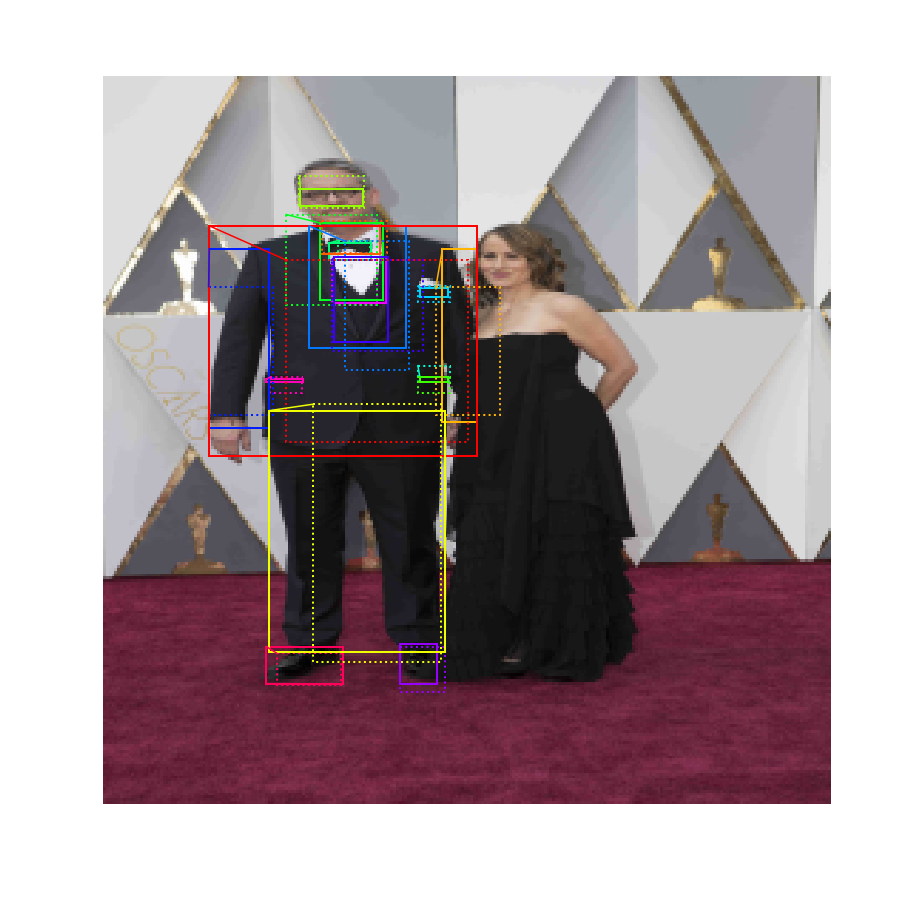

In [37]:
# Display positive anchors before refinement (dotted) and
# after refinement (solid).
visualize.draw_boxes(image, boxes=positive_anchors, refined_boxes=refined_anchors, ax=get_ax())

### 1.b RPN Predictions
Here we run the RPN graph and display its predictions. Tensorflows non max suppression is used.

In [38]:
# Run RPN sub-graph
pillar = model.keras_model.get_layer("ROI").output  # node to start searching from

nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV2:0")

rpn = model.run_graph([image], [
    ("rpn_class", model.keras_model.get_layer("rpn_class").output),
    ("pre_nms_anchors", model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
    ("refined_anchors", model.ancestor(pillar, "ROI/refined_anchors:0")),
    ("refined_anchors_clipped", model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
    ("post_nms_anchor_ix", nms_node),
    ("proposals", model.keras_model.get_layer("ROI").output),
])

rpn_class                shape: (1, 16368, 2)         min:    0.00000  max:    1.00000  float32
pre_nms_anchors          shape: (1, 6000, 4)          min:   -0.35494  max:    1.10396  float32
refined_anchors          shape: (1, 6000, 4)          min:   -0.37872  max:    1.16747  float32
refined_anchors_clipped  shape: (1, 6000, 4)          min:    0.00000  max:    1.00000  float32
post_nms_anchor_ix       shape: (1000,)               min:    0.00000  max: 1134.00000  int32
proposals                shape: (1, 1000, 4)          min:    0.00000  max:    0.99978  float32


#### Show top anchors by score(before refinement)

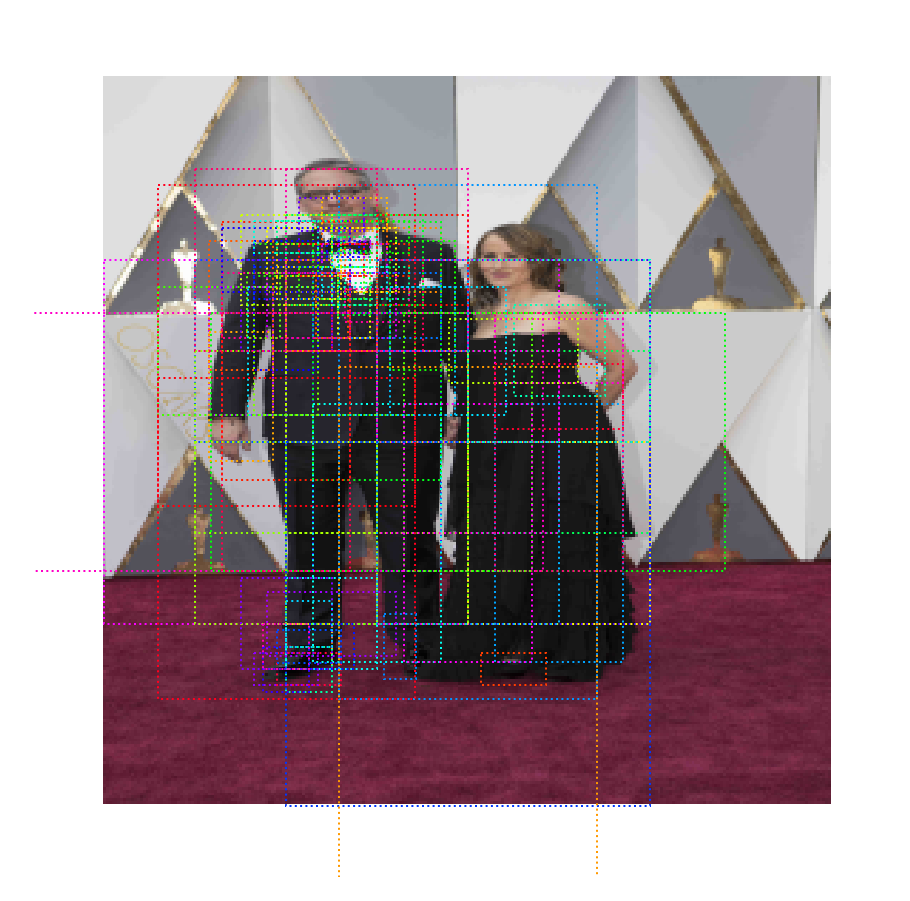

In [39]:
limit = 100
sorted_anchor_ids = np.argsort(rpn['rpn_class'][:,:,1].flatten())[::-1]
visualize.draw_boxes(image, boxes=model.anchors[sorted_anchor_ids[:limit]], ax=get_ax())

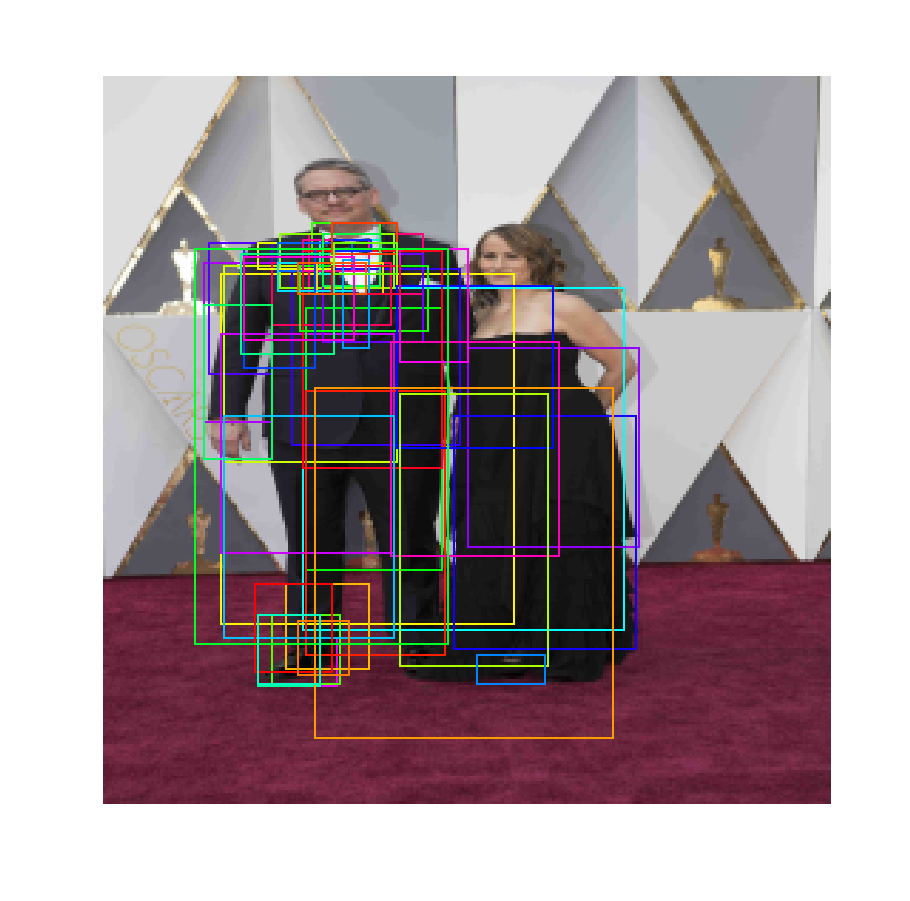

In [40]:
# Show final proposals
# These are the same as the previous step (refined anchors 
# after NMS) but with coordinates normalized to [0, 1] range.
limit = 50
# Convert back to image coordinates for display
h, w = config.IMAGE_SHAPE[:2]
proposals = rpn['proposals'][0, :limit] * np.array([h, w, h, w])
visualize.draw_boxes(image, refined_boxes=proposals, ax=get_ax())

## Stage 2: Proposal Classification
This stage takes the region proposals from the RPN and classifies them.

### 2.a Proposal Classification
Run the classifier heads on proposals to generate class propbabilities and bounding box regressions.

In [41]:
# Get input and output to classifier and mask heads.
mrcnn = model.run_graph([image], [
    ("proposals", model.keras_model.get_layer("ROI").output),
    ("probs", model.keras_model.get_layer("mrcnn_class").output),
    ("deltas", model.keras_model.get_layer("mrcnn_bbox").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
])

proposals                shape: (1, 1000, 4)          min:    0.00000  max:    0.99978  float32
probs                    shape: (1, 1000, 47)         min:    0.00000  max:    0.99992  float32
deltas                   shape: (1, 1000, 47, 4)      min:   -4.54924  max:    4.64236  float32
masks                    shape: (1, 100, 28, 28, 47)  min:    0.00000  max:    0.99984  float32
detections               shape: (1, 100, 6)           min:    0.00000  max:   32.00000  float32


5 detections: ['shoe' 'pants' 'collar' 'dress' 'sleeve']


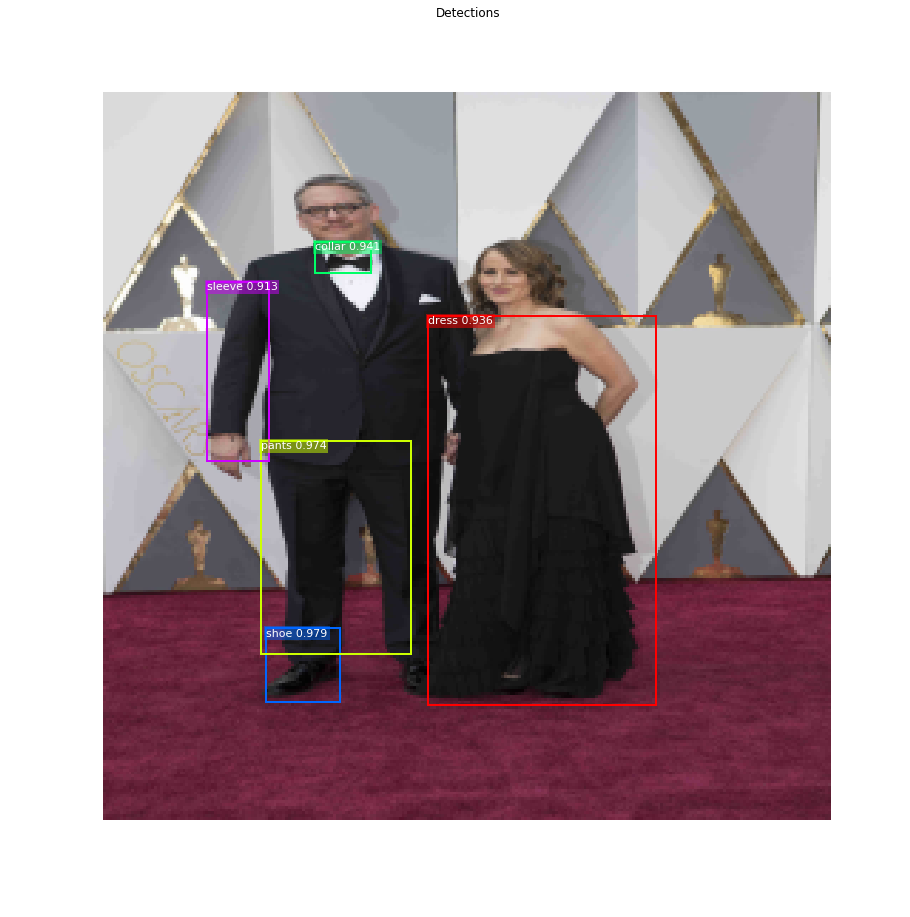

In [42]:
# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]
detections = mrcnn['detections'][0, :det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset_train.class_names)[det_class_ids]))

captions = ["{} {:.3f}".format(dataset_train.class_names[int(c)], s) if c > 0 else ""
            for c, s in zip(detections[:, 4], detections[:, 5])]
visualize.draw_boxes(
    image, 
    refined_boxes=utils.denorm_boxes(detections[:, :4], image.shape[:2]),
    visibilities=[2] * len(detections),
    captions=captions, title="Detections",
    ax=get_ax())

### 2.c Step by Step Detection

Here we dive deeper into the process of processing the detections. 
As we proceed, the proposed detections are narrowed down by filtering by class, score, applying non-max suppression (NMS).

In [43]:
# Proposals are in normalized coordinates. Scale them
# to image coordinates.
h, w = config.IMAGE_SHAPE[:2]
proposals = np.around(mrcnn["proposals"][0] * np.array([h, w, h, w])).astype(np.int32)

# Class ID, score, and mask per proposal
roi_class_ids = np.argmax(mrcnn["probs"][0], axis=1)
roi_scores = mrcnn["probs"][0, np.arange(roi_class_ids.shape[0]), roi_class_ids]
roi_class_names = np.array(dataset_train.class_names)[roi_class_ids]
roi_positive_ixs = np.where(roi_class_ids > 0)[0]

# How many ROIs vs empty rows?
print("{} Valid proposals out of {}".format(np.sum(np.any(proposals, axis=1)), proposals.shape[0]))
print("{} Positive ROIs".format(len(roi_positive_ixs)))

# Class counts
print(list(zip(*np.unique(roi_class_names, return_counts=True))))

1000 Valid proposals out of 1000
75 Positive ROIs
[('BG', 925), ('coat', 1), ('collar', 7), ('dress', 10), ('jacket', 3), ('lapel', 13), ('neckline', 4), ('pants', 11), ('shoe', 15), ('sleeve', 8), ('top', 3)]


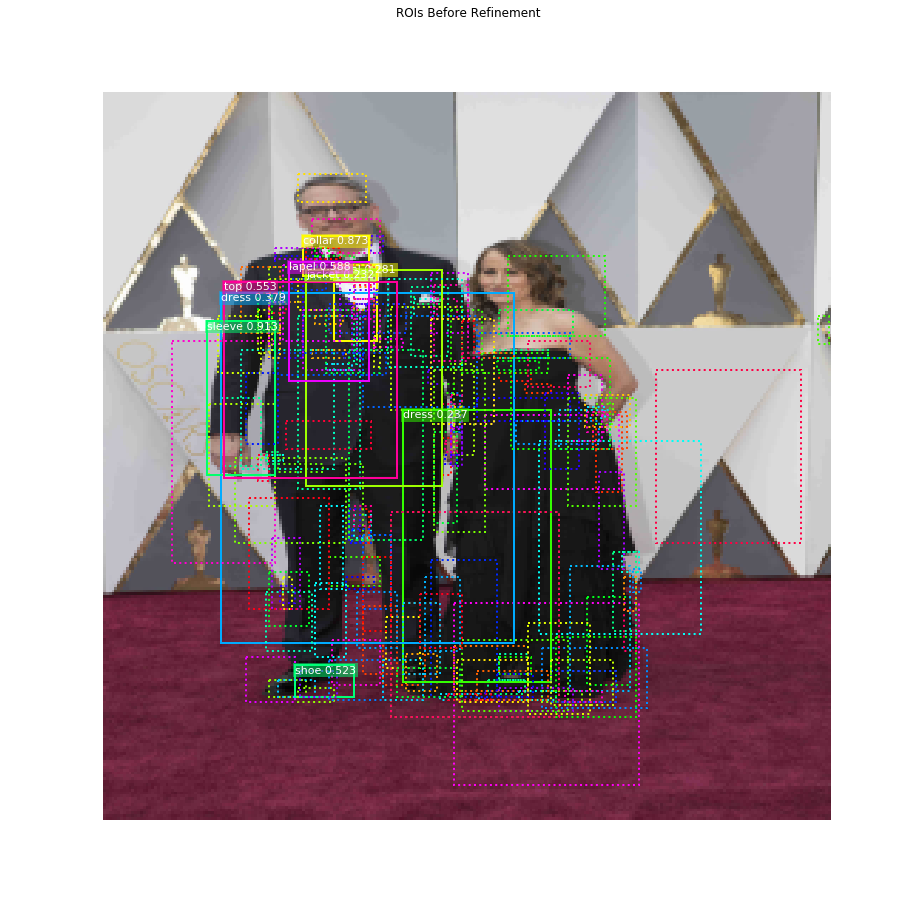

In [44]:
# Display a random sample of proposals.
# Proposals classified as background are dotted, and
# the rest show their class and confidence score.
limit = 200
ixs = np.random.randint(0, proposals.shape[0], limit)
captions = ["{} {:.3f}".format(dataset_train.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[ixs], roi_scores[ixs])]
visualize.draw_boxes(image, boxes=proposals[ixs],
                     visibilities=np.where(roi_class_ids[ixs] > 0, 2, 1),
                     captions=captions, title="ROIs Before Refinement",
                     ax=get_ax())

#### Apply Bounding Box Refinement
refined_proposals is of dimenion Nx4, N is the number of proposals (1000). The four columns represent the xy coordinates of the box (y1, x1, y2, x2)

roi_bbox_specific        shape: (1000, 4)             min:   -3.81998  max:    4.08449  float32
refined_proposals        shape: (1000, 4)             min:    8.00000  max:  256.00000  int32


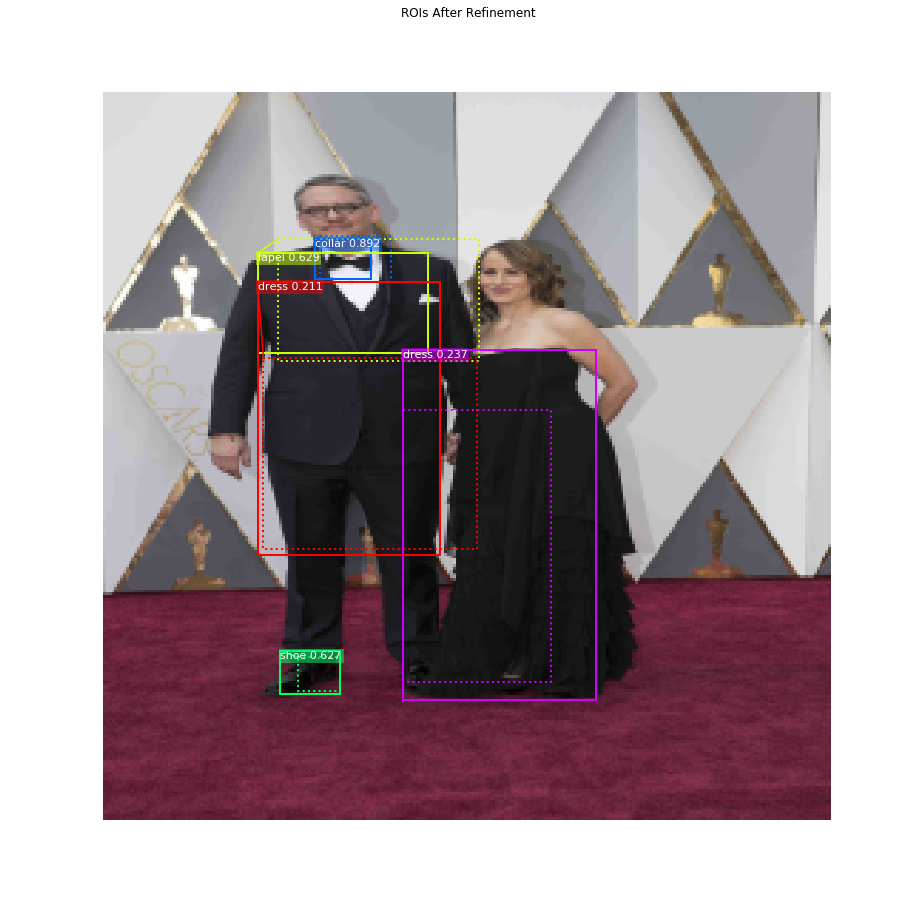

In [45]:
# Class-specific bounding box shifts.
roi_bbox_specific = mrcnn["deltas"][0, np.arange(proposals.shape[0]), roi_class_ids]
log("roi_bbox_specific", roi_bbox_specific)

# Apply bounding box transformations
# Shape: [N, (y1, x1, y2, x2)]
refined_proposals = utils.apply_box_deltas(
    proposals, roi_bbox_specific * config.BBOX_STD_DEV).astype(np.int32)
log("refined_proposals", refined_proposals)

# Show positive proposals
# ids = np.arange(roi_boxes.shape[0])  # Display all
limit = 5
ids = np.random.randint(0, len(roi_positive_ixs), limit)  # Display random sample
captions = ["{} {:.3f}".format(dataset_train.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[roi_positive_ixs][ids], roi_scores[roi_positive_ixs][ids])]
visualize.draw_boxes(image, boxes=proposals[roi_positive_ixs][ids],
                     refined_boxes=refined_proposals[roi_positive_ixs][ids],
                     visibilities=np.where(roi_class_ids[roi_positive_ixs][ids] > 0, 1, 0),
                     captions=captions, title="ROIs After Refinement",
                     ax=get_ax())

#### Filter Background Detections

In [46]:
# Filter out boxes classified as background where class_id == 0
keep = np.where(roi_class_ids > 0)[0]
print("Keep {} detections:\n{}".format(keep.shape[0], keep))

Keep 75 detections:
[  0   1   2   3   4   5   6   7   8   9  10  12  13  14  17  18  19  20
  24  27  28  30  31  36  37  38  43  44  45  53  54  56  60  62  63  67
  68  74  79  82  87  92  98 109 113 118 127 133 140 142 147 150 172 183
 184 235 242 310 319 332 489 503 517 523 557 608 619 649 662 761 784 789
 836 943 985]


#### Filter Low Confidence Detections

In [47]:
print("Detection threshhold: ", config.DETECTION_MIN_CONFIDENCE)

Detection threshhold:  0.9


In [48]:
keep = np.intersect1d(keep, np.where(roi_scores >= config.DETECTION_MIN_CONFIDENCE)[0])
print("Remove boxes below {} confidence. Keep {}:\n{}".format(
    config.DETECTION_MIN_CONFIDENCE, keep.shape[0], keep))

Remove boxes below 0.9 confidence. Keep 13:
[  4   8  13  14  19  24  30  36  38  45  82 127 142]


#### Per-Class Non-Max Suppression (NMS)
An object may have been detected multiple times, reduce to best detection per object. This process looks at the best probabilities. The others found with a high overlap (IoU) will be suppressed. This is done for each object found.

In [49]:
# Apply per-class non-max suppression
pre_nms_boxes = refined_proposals[keep]
pre_nms_scores = roi_scores[keep]
pre_nms_class_ids = roi_class_ids[keep]

nms_keep = []
for class_id in np.unique(pre_nms_class_ids):
    # Pick detections of this class
    ixs = np.where(pre_nms_class_ids == class_id)[0]
    # Apply NMS
    class_keep = utils.non_max_suppression(pre_nms_boxes[ixs], 
                                            pre_nms_scores[ixs],
                                            config.DETECTION_NMS_THRESHOLD)
    # Map indicies
    class_keep = keep[ixs[class_keep]]
    nms_keep = np.union1d(nms_keep, class_keep)
    print("{:22}: {} -> {}".format(dataset_train.class_names[class_id][:20], 
                                   keep[ixs], class_keep))

keep = np.intersect1d(keep, nms_keep).astype(np.int32)
print("\nKept after per-class NMS: {}\n{}".format(keep.shape[0], keep))

pants                 : [ 19  30 142] -> [30]
dress                 : [127] -> [127]
shoe                  : [ 8 13 14 36 38 45 82] -> [14]
collar                : [4] -> [4]
sleeve                : [24] -> [24]

Kept after per-class NMS: 5
[  4  14  24  30 127]


#### Show the remaining detections

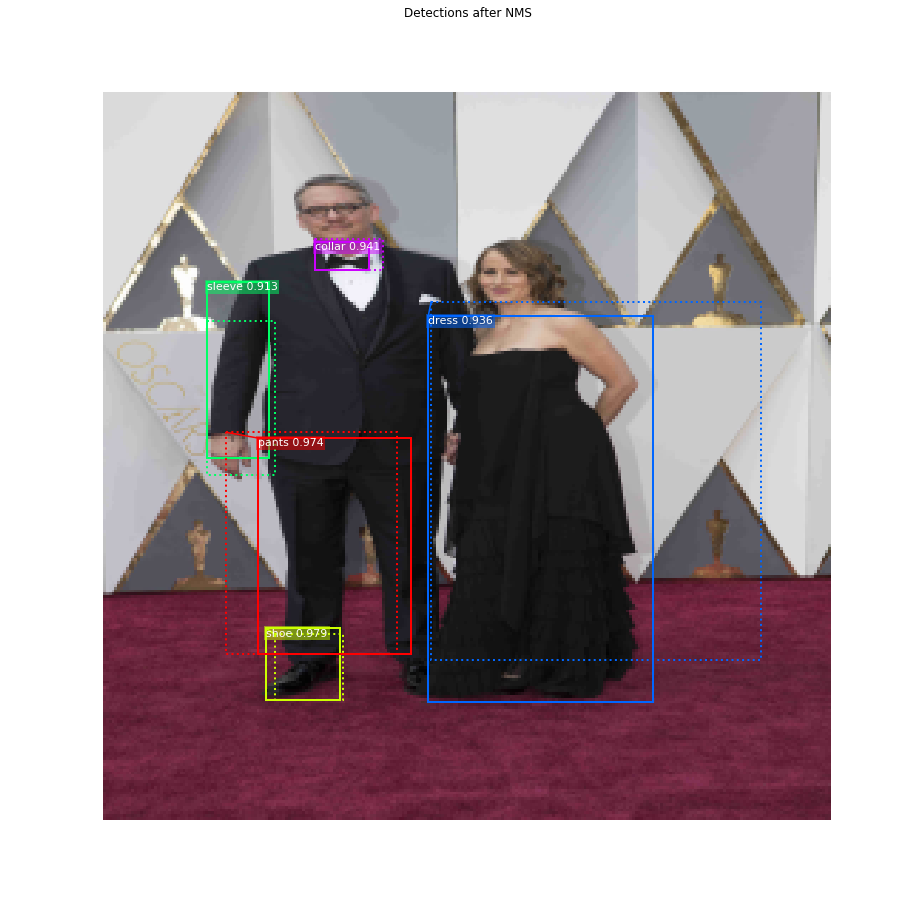

In [50]:
# Show final detections
ixs = np.arange(len(keep))  # Display all
# ixs = np.random.randint(0, len(keep), 10)  # Display random sample
captions = ["{} {:.3f}".format(dataset_train.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[keep][ixs], roi_scores[keep][ixs])]
visualize.draw_boxes(
    image, boxes=proposals[keep][ixs],
    refined_boxes=refined_proposals[keep][ixs],
    visibilities=np.where(roi_class_ids[keep][ixs] > 0, 1, 0),
    captions=captions, title="Detections after NMS",
    ax=get_ax())

## Stage 3: Generating Masks

This stage takes the detections (refined bounding boxes and class IDs) from the previous layer and runs the mask head to generate segmentation masks for every instance.

### 3.a Target Masks
These are the training targets for the mask branch

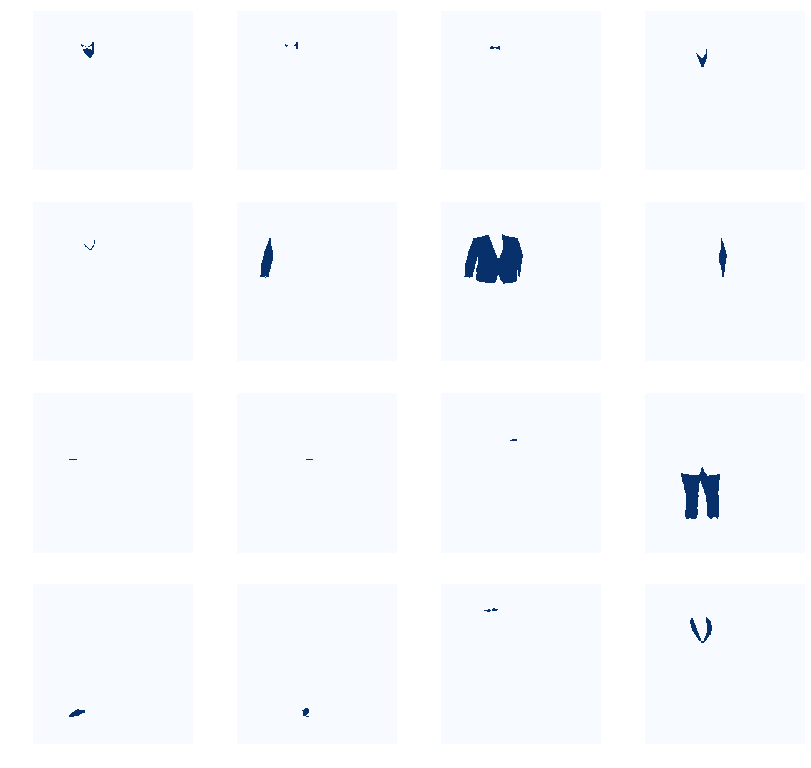

In [51]:
display_images(np.transpose(gt_mask, [2, 0, 1]), cmap="Blues")

### 3.b Predicted Masks

In [52]:
# Get predictions of mask head.  tuples of output layers is passed in.
mrcnn = model.run_graph([image], [
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
])

# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset_train.class_names)[det_class_ids]))

detections               shape: (1, 100, 6)           min:    0.00000  max:   32.00000  float32
masks                    shape: (1, 100, 28, 28, 47)  min:    0.00000  max:    0.99984  float32
5 detections: ['shoe' 'pants' 'collar' 'dress' 'sleeve']


In [53]:
# Masks
det_boxes = utils.denorm_boxes(mrcnn["detections"][0, :, :4], image.shape[:2])
det_mask_specific = np.array([mrcnn["masks"][0, i, :, :, c] 
                              for i, c in enumerate(det_class_ids)])
det_masks = np.array([utils.unmold_mask(m, det_boxes[i], image.shape)
                      for i, m in enumerate(det_mask_specific)])
log("det_mask_specific", det_mask_specific)
log("det_masks", det_masks)

det_mask_specific        shape: (5, 28, 28)           min:    0.00005  max:    0.99984  float32
det_masks                shape: (5, 256, 256)         min:    0.00000  max:    1.00000  bool


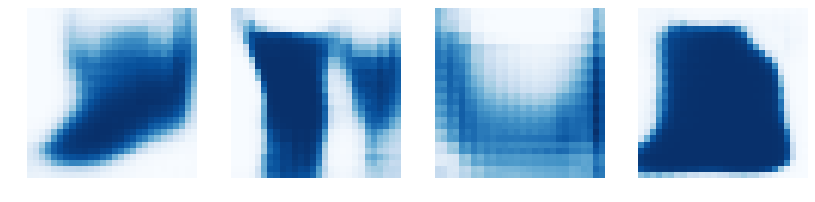

In [54]:
display_images(det_mask_specific[:4] * 255, cmap="Blues", interpolation="none")

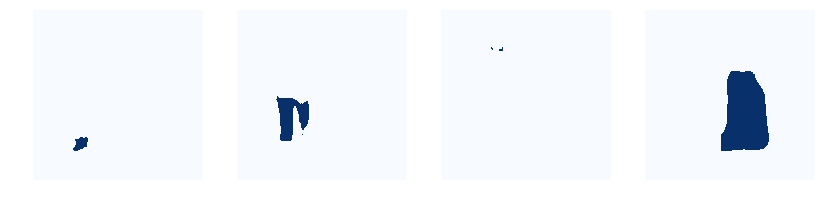

In [55]:
display_images(det_masks[:4] * 255, cmap="Blues", interpolation="none")

## Visualize Activations
In some cases it helps to look at the output from different layers and visualize them to catch issues and odd patterns.

In [56]:
# Get activations of a few sample layers
activations = model.run_graph([image], [
    ("input_image",        model.keras_model.get_layer("input_image").output),
    ("res2c_out",          model.keras_model.get_layer("res2c_out").output),
    ("res3c_out",          model.keras_model.get_layer("res3c_out").output),
    ("res4w_out",          model.keras_model.get_layer("res4w_out").output),  # for resnet100
    ("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
    ("roi",                model.keras_model.get_layer("ROI").output),
])

input_image              shape: (1, 256, 256, 3)      min: -120.70000  max:  150.10001  float32
res2c_out                shape: (1, 64, 64, 256)      min:    0.00000  max:   34.37965  float32
res3c_out                shape: (1, 32, 32, 512)      min:    0.00000  max:   32.40414  float32
res4w_out                shape: (1, 16, 16, 1024)     min:    0.00000  max:   61.10297  float32
rpn_bbox                 shape: (1, 16368, 4)         min:   -9.18620  max:   14.39018  float32
roi                      shape: (1, 1000, 4)          min:    0.00000  max:    0.99978  float32


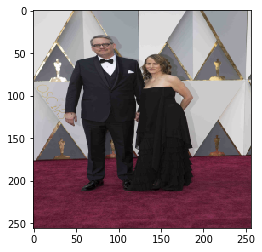

In [57]:
# Input image (normalized)
_ = plt.imshow(modellib.unmold_image(activations["input_image"][0],config))

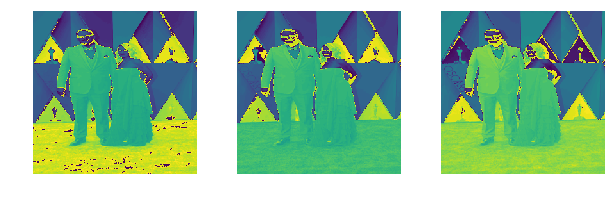

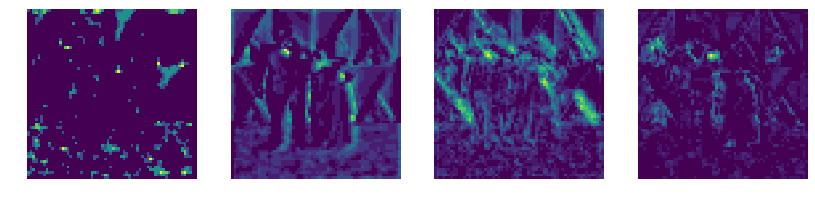

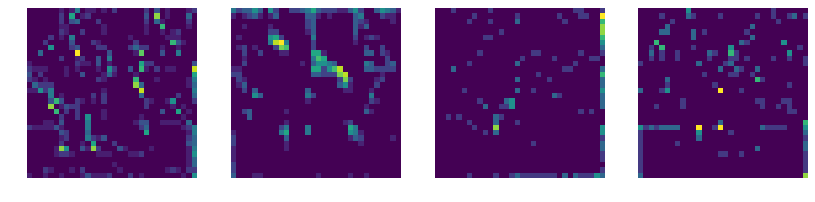

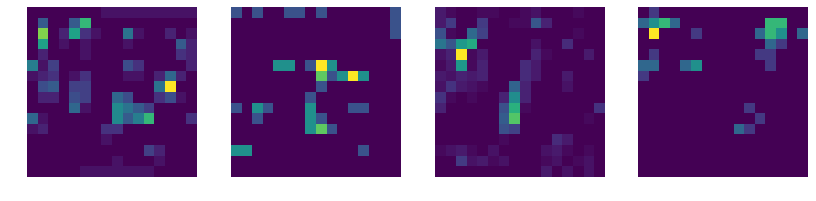

In [58]:
# Backbone feature map
display_images(np.transpose(activations["input_image"][0,:,:,:4], [2, 0, 1]), cols=4)
display_images(np.transpose(activations["res2c_out"][0,:,:,:4], [2, 0, 1]), cols=4)
display_images(np.transpose(activations["res3c_out"][0,:,:,:4], [2, 0, 1]), cols=4)
display_images(np.transpose(activations["res4w_out"][0,:,:,:4], [2, 0, 1]), cols=4)